In [55]:
from simtk import openmm, unit
from simtk.openmm import app
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
def run_double_well(mass, Eo, a, b,
                   temperature, friction, integration_timestep, initial_position,
                   saving_time, simulation_time):
    
    system = openmm.System()
    system.addParticle(mass)
    force = openmm.CustomExternalForce('A*x^4+B*x^2+C*x + D*(y^2+z^2)')
    
    k = 8.0*Eo/(a**2) # stiffness of the armonic potential for coordinates Y and Z
    A = Eo/(a**4)
    B = -2.0*Eo/(a**2)
    C = -b/a
    D = k/2.0
    
    force.addGlobalParameter('A', A)
    force.addGlobalParameter('B', B)
    force.addGlobalParameter('C', C)
    force.addGlobalParameter('D', D)
    
    force.addParticle(0)
    system.addForce(force)
    
    integrator = openmm.LangevinIntegrator(temperature, friction, integration_timestep)
    platform = openmm.Platform.getPlatformByName('CUDA')
    context = openmm.Context(system, integrator, platform)
    
    initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
    initial_positions[0,0]= initial_position    
    context.setPositions(initial_positions)

    initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds
    context.setVelocities(initial_velocities)
    
    saving_steps = int(saving_time/integration_timestep)
    simulation_steps = int(simulation_time/integration_timestep)
    n_saving_periods = int(simulation_steps/saving_steps)
    
    n_frames = n_saving_periods + 1
    trajectory =  np.zeros([n_frames, 1, 3], np.float32) * unit.nanometers
    time = np.zeros([n_frames], np.float32) * unit.nanoseconds
    
    trajectory[0, :, :] = initial_positions
    time[0]= 0 * unit.picoseconds
    
    for ii in range(n_saving_periods):
        integrator.step(saving_steps)
        state = context.getState(getPositions=True)
        trajectory[ii+1, :, :] = state.getPositions()
        time[ii+1]=state.getTime()
    
    return time, trajectory

In [3]:
mass = 100.0 * unit.amu
Eo=4.0 * unit.kilocalories_per_mole
a=1.0 * unit.nanometers
b=0.5 * unit.kilocalories_per_mole

temperature = 300.0*unit.kelvin
friction = 0.5/unit.picoseconds
integration_timestep = 0.02 * unit.picoseconds

saving_time = 0.1 * unit.picoseconds
simulation_time = 10.0 * unit.nanoseconds

initial_position = 1.0 * unit.nanometers

In [4]:
time, trajectory = run_double_well(mass, Eo, a, b,
                   temperature, friction, integration_timestep, initial_position,
                   saving_time, simulation_time)

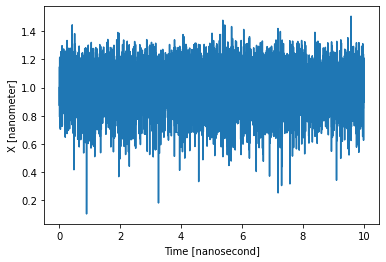

In [5]:
plt.plot(time, trajectory[:, 0, 0])
plt.xlabel('Time [{}]'.format(time.unit))
plt.ylabel('X [{}]'.format(trajectory.unit))
plt.show()

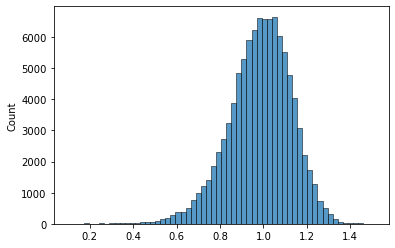

In [6]:
sns.histplot(trajectory[:,0,0], bins=60)
plt.show()

In [7]:
def get_probability_left (trajectory, barrier=0.0*unit.nanometers):
    occupancy = (trajectory[:, 0, 0] < barrier).sum()
    n_frames = trajectory.shape[0]
    return occupancy/n_frames

def get_probability_right (trajectory, barrier=0.0*unit.nanometers):
    occupancy = (trajectory[:, 0, 0] >= barrier).sum()
    n_frames = trajectory.shape[0]
    return occupancy/n_frames

In [8]:
get_probability_left(trajectory)

0.0

In [9]:
get_probability_right(trajectory)

1.0

# Probability distribution from statistical mechanics

In [10]:
def potential_energy(Eo, a, b, x):
    Ep = Eo * ( (x/a)**4 - 2.0 * (x/a)**2 ) - b*(x/a)
    return Ep

In [11]:
potential_energy(Eo, a, b, 1.0*unit.nanometers)

Quantity(value=-4.5, unit=kilocalorie/mole)

In [12]:
coor_x = np.linspace(-2.0, 2.0, 100) * unit.nanometers

In [13]:
Ep_x = potential_energy(Eo, a, b, coor_x)

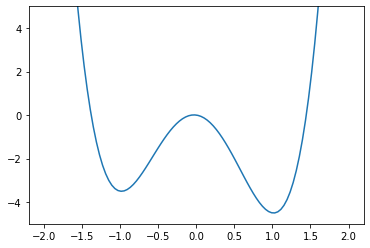

In [14]:
plt.plot(coor_x, Ep_x)
plt.ylim([-5.0, 5.0])
plt.show()

In [15]:
def partition_function_x(Eo, a, b, temperature, x):
    kB=unit.BOLTZMANN_CONSTANT_kB * unit.AVOGADRO_CONSTANT_NA
    beta = 1.0/(kB*temperature)
    Ep = potential_energy(Eo, a, b, x)
    z_x = np.exp(-beta*Ep)
    return z_x

In [16]:
z_x = partition_function_x(Eo, a, b, temperature, coor_x)

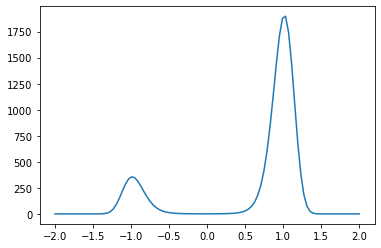

In [17]:
plt.plot(coor_x, z_x)
plt.show()

In [18]:
x_integral = np.linspace(-3.0, 3.0, 1000) * unit.nanometers

In [19]:
dx_integral = (x_integral[1:]-x_integral[:-1]).mean() / unit.nanometers

In [20]:
dx_integral

0.006006006006006006

In [21]:
Z=0.0
for x in x_integral:
    Z+=partition_function_x(Eo, a, b, temperature, x)*dx_integral

In [22]:
Z

788.6725442313782

In [23]:
def total_partition_function(Eo, a, b, temperature):
    x_integral = np.linspace(-3.0, 3.0, 1000) * unit.nanometers
    dx_integral = (x_integral[1:]-x_integral[:-1]).mean()/unit.nanometers
    Z=0.0
    for x in x_integral:
        Z+=partition_function_x(Eo, a, b, temperature, x)*dx_integral
    return Z

In [24]:
Z = total_partition_function(Eo, a, b, temperature)

In [25]:
def probability_x(Eo, a, b, temperature, x, Z):
    z_x = partition_function_x(Eo, a, b, temperature, x)
    return z_x/Z

In [28]:
p_x = probability_x(Eo, a, b, temperature, coor_x, Z)

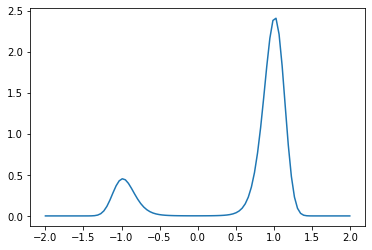

In [29]:
plt.plot(coor_x, p_x)
plt.show()

In [31]:
P_left = 0.0
x_integral = np.linspace(-3.0, 0.0, 1000) * unit.nanometers
dx_integral = (x_integral[1:]-x_integral[:-1]).mean() / unit.nanometers
for x in x_integral:
    P_left+=probability_x(Eo, a, b, temperature, x, Z)*dx_integral

In [32]:
P_left

0.1652746118179859

In [36]:
P_right = 1.0-P_left

In [37]:
P_right

0.8347253881820141

In [38]:
K_d=P_left/P_right

In [39]:
K_d

0.19799878398085494

In [53]:
x_mean = 0.0 * unit.nanometers
x_integral = np.linspace(-3.0, 3.0, 1000) * unit.nanometers
dx_integral = (x_integral[1:]-x_integral[:-1]).mean() / unit.nanometers
for x in x_integral:
    x_mean+=x*probability_x(Eo, a, b, temperature, x, Z)*dx_integral

In [54]:
x_mean

Quantity(value=0.6656024595812997, unit=nanometer)

## Lets make some statistics

In [58]:
simulation_time = 10.0 * unit.nanoseconds
p_left_runs =[]
x_mean_runs =[]

In [59]:
for run_index in tqdm(range(10)):
    time, trajectory = run_double_well(mass, Eo, a, b, temperature, friction,
                                       integration_timestep, initial_position,
                                       saving_time, simulation_time)
    p_left = get_probability_left(trajectory)
    p_left_runs.append(p_left)
    x_mean_runs.append(trajectory[:,0,0].mean())

100%|██████████| 10/10 [08:30<00:00, 51.03s/it]


In [60]:
p_left_runs

[0.0,
 0.00013999860001399987,
 0.2922570774292257,
 0.0,
 0.0,
 0.0,
 0.0,
 8.99991000089999e-05,
 0.0,
 0.42865571344286557]

In [61]:
x_mean_runs

[Quantity(value=0.9855913, unit=nanometer),
 Quantity(value=0.98389196, unit=nanometer),
 Quantity(value=0.42059088, unit=nanometer),
 Quantity(value=0.98639405, unit=nanometer),
 Quantity(value=0.9853581, unit=nanometer),
 Quantity(value=0.98551583, unit=nanometer),
 Quantity(value=0.98162997, unit=nanometer),
 Quantity(value=0.9873362, unit=nanometer),
 Quantity(value=0.98395914, unit=nanometer),
 Quantity(value=0.15569489, unit=nanometer)]